# Summary

Starting from one day tick data for a single financical product, we try to predict events where a top-of-book price level "goes." More precisely, for ticks that do have a bid/ask, we try to predict the probability that in the next-in-time tick which also has a bid/ask, the bid/ask will be lower/higher.

We first explore the dataset and extract a subset of the ticks which is useful for model building. We then investigate a relatively small number of simple features which trading intuition suggests to be correlated with our quantity of interest. After extracting these features, we compare the performance of three models on a test set:
* a baseline model which simply predicts the frequency of "level goes" events in the training set
* logistic regression
* a gradient boosting model

As expected, we find these models to provide increasingly better results.

We view this challenge as a regression problem as opposed to a classification problem -- classification would prematurely combine model building and decision theory and should depend on the relative cost of false positives and negatives. We use a maximum-likelihood approach for training and comparing different models. That is, the quantity we seek to minimize is the binary cross-entropy or deviance on the test set.

In [1]:
%matplotlib inline

import json
import math
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from collections import Counter
from datetime import date
from datetime import datetime

from sklearn import ensemble
from sklearn.linear_model import LogisticRegressionCV
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split

# Data exploration

In [2]:
def json_reader(file):
    for line in open(file, mode="r"):
        yield json.loads(line)

In [3]:
data = list(json_reader('challenge.json'))

In [4]:
N = len(data); N

1262193

In [5]:
{key for tick in data for key in tick.keys()}

{'Ask', 'Bid', 'Trade', 'time'}

In [6]:
all('time' in tick and 'Trade' in tick for tick in data)

True

In [7]:
all(('Ask' in tick and 'Bid' in tick) or ('Ask' not in tick and 'Bid' not in tick) for tick in data)

True

All ticks have a 'time' and a 'Trade' field (though the 'Trade' field can be empty). Not all of them have a 'Bid' and a 'Ask', but they always appear together.

In [8]:
times = [tick['time'] for tick in data]

In [9]:
def timestamp_to_str(timestamp):
    return datetime.fromtimestamp(timestamp // 10**9).strftime('%Y-%m-%d %H:%M:%S')

In [10]:
def str_to_timestamp(string, format='%Y-%m-%d %H:%M:%S'):
    return int(datetime.strptime(string, format).strftime("%s")) * 10**9

In [11]:
timestamp_to_str(min(times))

'2018-04-01 13:21:05'

In [12]:
timestamp_to_str(max(times))

'2018-04-01 22:15:31'

In [13]:
day = str_to_timestamp('2018-04-01', format='%Y-%m-%d')

In [14]:
def timestamp_to_hr(timestamp):
    return (timestamp - day) / 10**9 / 3600

In [15]:
hours = [timestamp_to_hr(t) for t in times]

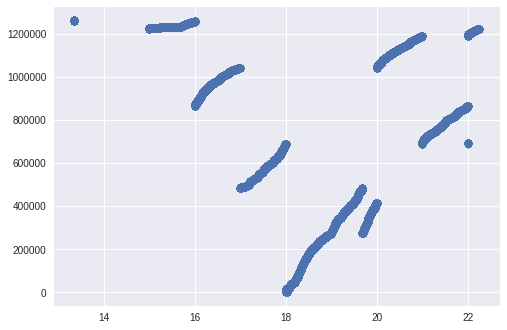

In [16]:
plt.scatter(hours, range(N));

The data is far from sorted by time -- there is even a segment where ticks whose time differs by many minutes are interleaved (see below).

In [148]:
hours[380100:380120]

[19.333011387855557,
 19.33301140937611,
 19.333011412468057,
 19.333012009383335,
 19.902661859003057,
 19.333134206872778,
 19.902661901006113,
 19.333134227156112,
 19.902661901006113,
 19.902670671169723,
 19.902670671169723,
 19.902778152836387,
 19.902778152836387,
 19.902800671838058,
 19.902800671838058,
 19.90280114265389,
 19.9028089295,
 19.902821331461112,
 19.90282743264278,
 19.90282743264278]

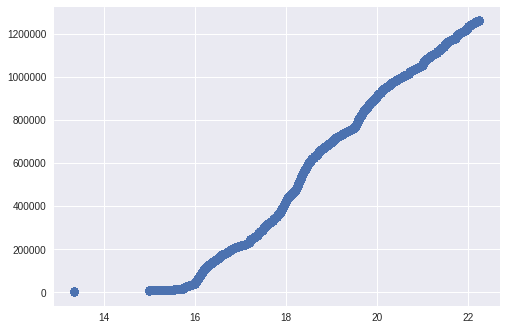

In [18]:
plt.scatter(sorted(hours), range(N));

In [145]:
sorted([t for t in hours if t > 14])[:10]

[15.000285134063335,
 15.000285134063335,
 15.000286216631666,
 15.000286216631666,
 15.000286216631666,
 15.000286216631666,
 15.000286216631666,
 15.000286216631666,
 15.000286216631666,
 15.000286216631666]

It seems that 'real' trading in this instrument on 2018-04-01 started at 15:00 (in the time zone of the timestamps). The density of ticks between 15:00 and 15:45 is notably lower than after 15:45.

In [20]:
def bid(tick):
    return max([level['price'] for level in tick['Bid']]) 

def ask(tick):
    return min([level['price'] for level in tick['Ask']]) 

def bsize(tick):
    return max(tick['Bid'], key=lambda level: level['price'])['volume']

def asize(tick):
    return min(tick['Ask'], key=lambda level: level['price'])['volume']

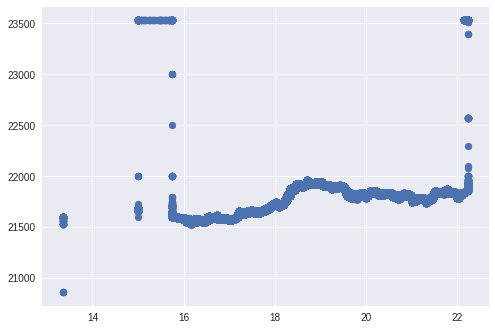

In [21]:
plt.scatter(*zip(*[(timestamp_to_hr(tick['time']), bid(tick)) for tick in data if tick.get('Bid', []) != []]));

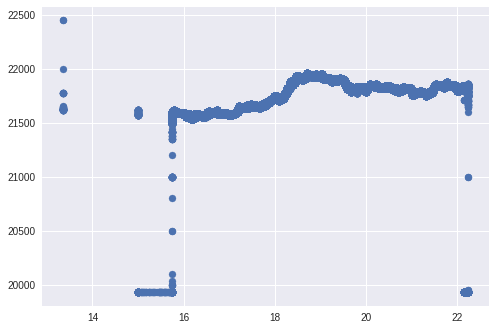

In [22]:
plt.scatter(*zip(*[(timestamp_to_hr(tick['time']), ask(tick)) for tick in data if tick.get('Ask', []) != []]));

In [23]:
Counter(timestamp_to_str(tick['time']) for tick in data if ('Bid' not in tick or 'Ask' not in tick) and tick['Trade'] != {})

Counter({'2018-04-01 15:45:01': 693,
         '2018-04-01 16:51:40': 1,
         '2018-04-01 16:53:38': 5,
         '2018-04-01 16:55:42': 1,
         '2018-04-01 17:00:03': 1,
         '2018-04-01 17:02:12': 1,
         '2018-04-01 19:33:40': 1,
         '2018-04-01 19:34:41': 2,
         '2018-04-01 19:40:51': 1,
         '2018-04-01 19:41:14': 1,
         '2018-04-01 20:21:44': 6,
         '2018-04-01 20:22:01': 1,
         '2018-04-01 20:22:03': 1,
         '2018-04-01 20:23:30': 5,
         '2018-04-01 20:23:55': 1,
         '2018-04-01 20:27:05': 1,
         '2018-04-01 20:35:13': 2,
         '2018-04-01 20:43:27': 4,
         '2018-04-01 20:44:05': 1,
         '2018-04-01 20:44:39': 2,
         '2018-04-01 22:15:01': 628})

Crossed markets (bid > ask) and trades without a bid and ask mostly occur at 15:45 and 22:15; likely the opening and closing auction of this instrument. We restrict to ticks between these two times. We also discard ticks that have neither a bid/ask nor a trade and thus are useless for model building. Finally, there's a small number of trade ticks between the two auctions that don't have a bid/ask (see above); for simplicity, we also discard these.

We also sort the ticks by time.

In [24]:
data = [tick for tick in data 
        if tick['time'] > str_to_timestamp('2018-04-01 15:45:30')
        and tick['time'] < str_to_timestamp('2018-04-01 22:10:00')
        and 'Ask' in tick and 'Bid' in tick
       ]
data = sorted(data, key=lambda tick: tick['time'])
N = len(data); N

831207

In [25]:
(data[-1]['time'] - data[0]['time']) / N / 10**9

0.027754493248430292

On average, we have one (non-empty) tick per 28ms.

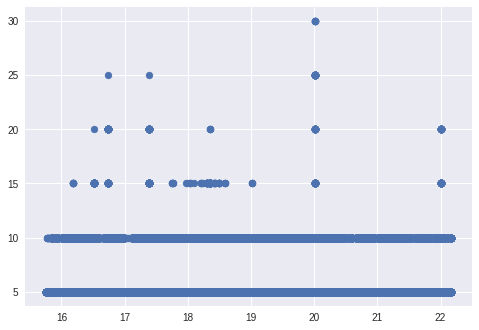

In [26]:
plt.scatter(*zip(*[(timestamp_to_hr(tick['time']), ask(tick) - bid(tick)) for tick in data]));

In [27]:
Counter(ask(tick) - bid(tick) for tick in data)

Counter({5.0: 803889, 10.0: 26569, 15.0: 505, 20.0: 187, 25.0: 49, 30.0: 8})

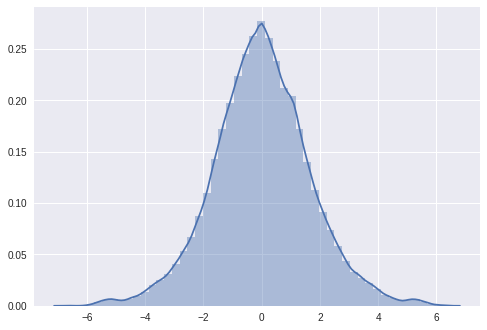

In [66]:
log_size_ratios = [math.log(asize(tick) / bsize(tick)) for tick in data]
sns.distplot(log_size_ratios);

In [29]:
ask_gone = {i for i in range(1, N) if ask(data[i]) > ask(data[i-1])}
bid_gone = {i for i in range(1, N) if bid(data[i]) < bid(data[i-1])}

In [30]:
len(ask_gone), len(bid_gone)

(5441, 5440)

In [31]:
len(ask_gone) / N, len(bid_gone) / N

(0.00654590252488249, 0.006544699455129709)

In [32]:
trades = [i for i in range(N) if data[i]['Trade'] != {}]
n_trades = len(trades)
n_trades / N

0.20311065715279106

In [33]:
len([i for i in trades if data[i]['Trade']['price'] in {bid(data[i-1]), ask(data[i-1])}]) / n_trades

1.0

In [34]:
len([i for i in trades if data[i]['Trade']['price'] in {bid(data[i]), ask(data[i])}]) / n_trades

0.9419820289408685

In [35]:
[(lag, len([i for i in bid_gone if data[i-lag]['Trade'] != {}]) / len(bid_gone)) for lag in range(4)]

[(0, 0.9047794117647059),
 (1, 0.6952205882352941),
 (2, 0.6659926470588236),
 (3, 0.6172794117647059)]

In [36]:
[(lag, len([i for i in ask_gone if data[i-lag]['Trade'] != {}]) / len(ask_gone)) for lag in range(4)]

[(0, 0.8956074251056791),
 (1, 0.6967469215217791),
 (2, 0.6643999264841022),
 (3, 0.6155118544385223)]

Summary of exploration so far:
* We have 831k ticks with a bid and an ask between the opening and closing auctions.
* On average, we have one tick per 28ms.
* Spreads are strictly positive, multiples of 5, and mostly 5.
* `bid-size / ask-size` is approximately log-normally distributed.
* 20% of the ticks are trades.
* Trades always happen at the previous bid or ask.
* For 94% of trades, the price level at which it happens persists.
* There are around 5440 'bid gone' and 'ask gone' events each, corresponding to around 0.7% of the ticks.
* In 90% of cases, these ticks are trades.
* Ticks before "bid gone" or "ask gone" are also much more likely to be trades than random ticks.

# Feature extraction

Trading intuition suggests that the following features might be useful for predicting "bid gone" events (analogously for "ask gone"):
* Trades on the bid are more likely to be followed by "bid gone" events than non-trades or trades on the ask.
* If the level immediately behind the bid is empty, the bid is more likely to "go."
* If the ask size is larger/smaller than the bid size, the bid is more/less likely to "go."
* If the bid size is large (irrespective of the ask size), the bid is less likely to "go." (A large bid size is more likely than a small one to consist of multiple orders, which are unlikely to cancel simultaneously.)
  
Before we start building models, let us briefly look at each of these features separately. 

We first define a utility function that allows us to visualize potentially non-linear dependencies.

In [37]:
def cumulative_sort_plot(x, y):
    '''Plot cumulative sums of y, with values sorted by x'''
    df = pd.DataFrame({'x': x, 'y': y})
    df = df.sort_values(by=['x'])
    fig, ax = plt.subplots()
    n = len(x)
    ax.scatter(range(n), df['y'].cumsum())
    plt.xlabel('count, sorted by x', fontsize=16)
    plt.ylabel('cumulative(y)', fontsize=16)
    print(f'Mean and std dev of x: {df["x"].mean()}, {df["x"].std()}')
    print('Percentile x-values:')
    for i in range(1, 10):
        print(f'{int(10*i)}%: {df.iloc[int(i/10*n)]["x"]}')

We also introduce a notion of "recent trade counts". Intuition suggest to add the volume of recent trades with some exponent in (0, 1). That is, a trade of size 100 should count more than a trade of size 10, but less than 10 trades of size 10.

In [38]:
def trade_counts(exponent, halflife, side):
    '''Sum of volume**exponent of recent trades
    Halflife in ns; side should be in {'bid', 'ask'}
    '''
    counts = np.zeros((N,), dtype=np.float64)
    cnt = 0.
    for i in range(1, N):
        delta_t = data[i]['time'] - data[i-1]['time']
        cnt *= 0.5**(delta_t/halflife)
        if 'volume' in data[i]['Trade']:
            pr = data[i]['Trade']['price']
            if (side == 'bid' and pr == bid(data[i-1])) or (side == 'ask' and pr == ask(data[i-1])):
                cnt += data[i]['Trade']['volume']**exponent
        counts[i] = cnt
    return counts

In [39]:
trade_cnts_bid = trade_counts(0.5, 10**4, 'bid')
trade_cnts_ask = trade_counts(0.5, 10**4, 'ask')

For each tick, we define a binary feature which tells whether the bid/ask "goes" on the next tick. (Recall that we only kept ticks that have a bid and an ask.) These is the target that we want to predict.

In [40]:
bid_goes_next_tick = np.array([i+1 in bid_gone for i in range(N)])
ask_goes_next_tick = np.array([i+1 in ask_gone for i in range(N)])

We see that "bid goes" events mostly happen when the count of recent trades on the bid is "non-zero". The count of recent trades on the ask seems to have little predictive power for "bid goes" events. The same is analogously true for "ask goes" events. We find these patterns to be very robust to the choice of halflife and exponent.

Mean and std dev of x: 1.1097143028932914, 4.920409035752229
Percentile x-values:
10%: 0.0
20%: 0.0
30%: 0.0
40%: 0.0
50%: 0.0
60%: 0.0
70%: 3.0844634048337754e-84
80%: 4.930659068955611e-13
90%: 1.0


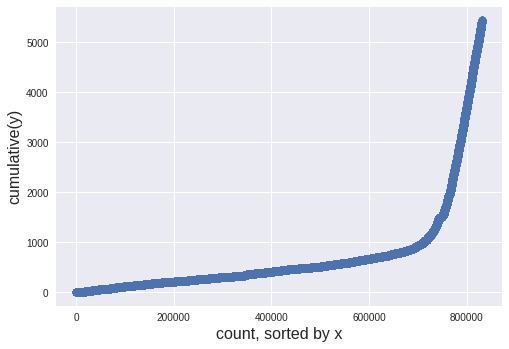

In [41]:
cumulative_sort_plot(trade_cnts_bid, bid_goes_next_tick)

Mean and std dev of x: 1.2096773071473135, 5.121831108950387
Percentile x-values:
10%: 0.0
20%: 0.0
30%: 0.0
40%: 0.0
50%: 0.0
60%: 0.0
70%: 5.115917992523951e-55
80%: 1.5627382028859458e-10
90%: 1.0855551284407128


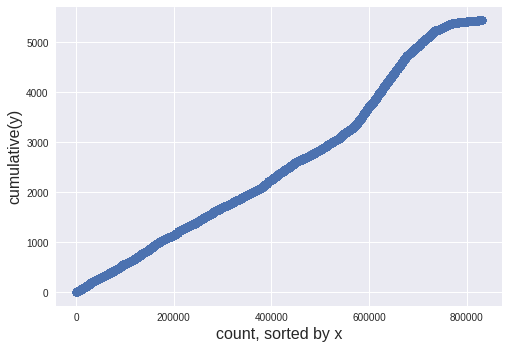

In [42]:
cumulative_sort_plot(trade_cnts_ask, bid_goes_next_tick)

Mean and std dev of x: 1.2096773071473135, 5.121831108950387
Percentile x-values:
10%: 0.0
20%: 0.0
30%: 0.0
40%: 0.0
50%: 0.0
60%: 0.0
70%: 5.115917992523951e-55
80%: 1.5627382028859458e-10
90%: 1.0855551284407128


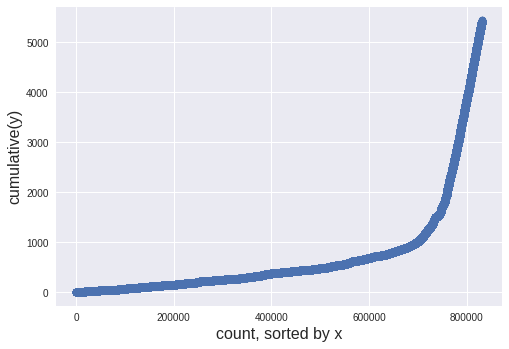

In [43]:
cumulative_sort_plot(trade_cnts_ask, ask_goes_next_tick)

Mean and std dev of x: 1.1097143028932914, 4.920409035752229
Percentile x-values:
10%: 0.0
20%: 0.0
30%: 0.0
40%: 0.0
50%: 0.0
60%: 0.0
70%: 3.0844634048337754e-84
80%: 4.930659068955611e-13
90%: 1.0


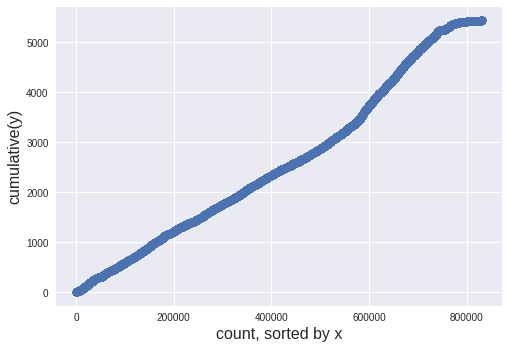

In [44]:
cumulative_sort_plot(trade_cnts_bid, ask_goes_next_tick)

In [45]:
MPV = 5

In [46]:
empty_behind_bid = [i for i, tick in enumerate(data) if bid(tick)-MPV not in {level['price'] for level in tick['Bid']}]
len(empty_behind_bid) / N

5.7747348133497434e-05

In [47]:
empty_behind_ask = [i for i, tick in enumerate(data) if ask(tick)+MPV not in {level['price'] for level in tick['Ask']}]
len(empty_behind_ask) / N

5.173199936959145e-05

In [48]:
len([i for i in empty_behind_bid if i+1 in bid_gone]) / len(empty_behind_bid)

0.0625

In [49]:
len([i for i in empty_behind_ask if i+1 in ask_gone]) / len(empty_behind_ask)

0.23255813953488372

If the level behind the bid/ask is empty, the probability that the bid/ask "goes" is over an order of magnitude higher than on a random tick. However, since ticks with an empty level behind the bid/ask are so rare (5e-5), this is unlikely to be a very valuable feature.

In [50]:
asizes = np.array([asize(tick) for tick in data])
bsizes = np.array([bsize(tick) for tick in data])

In [51]:
log_sz_ratios = np.log(asizes / bsizes)

In [52]:
np.average(log_sz_ratios), np.std(log_sz_ratios)

(-0.0021590780186464837, 1.6688908833158731)

In [53]:
np.average(log_sz_ratios[bid_goes_next_tick]), np.average(log_sz_ratios[ask_goes_next_tick])

(4.2922738667804516, -4.2518867494708186)

Before a level "goes", the logarithmic size ratio of the bid and ask differs on average by more than two standard deviations from its zero mean.

In [54]:
np.average(bid_goes_next_tick), np.average(ask_goes_next_tick)

(0.0065446994551297093, 0.00654590252488249)

In [55]:
np.average(bid_goes_next_tick[log_sz_ratios > 4]), np.average(ask_goes_next_tick[log_sz_ratios < -4])

(0.29817538633401602, 0.29815278045025978)

Similarly, if the size on the bid and ask differ by a ratio of more than e^4, the probability that the "bid/ask goes" is almost two orders of magnitude higher than the base rate.

Mean and std dev of x: -0.002159078018644254, 1.6688918872127223
Percentile x-values:
10%: -2.0281482472922856
20%: -1.2973468751033945
30%: -0.8034952377288106
40%: -0.39102442395337
50%: -0.01785761740000646
60%: 0.3566749439387324
70%: 0.7899970065498629
80%: 1.291757078429914
90%: 2.061129738037498


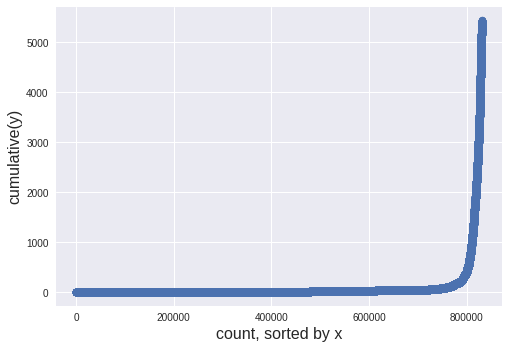

In [58]:
cumulative_sort_plot(log_sz_ratios, bid_goes_next_tick)

Mean and std dev of x: -0.002159078018644254, 1.6688918872127223
Percentile x-values:
10%: -2.0281482472922856
20%: -1.2973468751033945
30%: -0.8034952377288106
40%: -0.39102442395337
50%: -0.01785761740000646
60%: 0.3566749439387324
70%: 0.7899970065498629
80%: 1.291757078429914
90%: 2.061129738037498


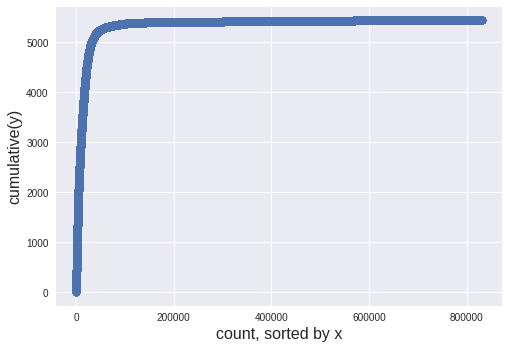

In [59]:
cumulative_sort_plot(log_sz_ratios, ask_goes_next_tick)

Almost all "bid/ask goes" events happen if the size ratio of the bid and the ask takes a value in the most extreme 10%.

Mean and std dev of x: 155.38878041209952, 108.74031660200203
Percentile x-values:
10%: 30
20%: 60
30%: 93
40%: 124
50%: 149
60%: 171
70%: 196
80%: 227
90%: 274


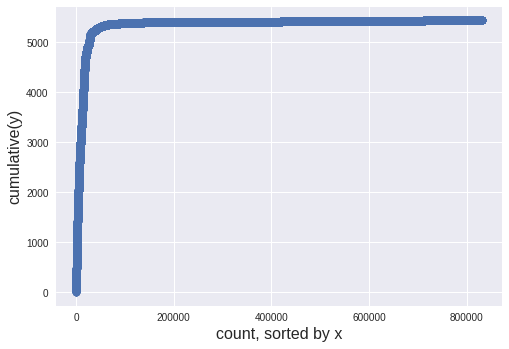

In [60]:
cumulative_sort_plot(bsizes, bid_goes_next_tick)

Mean and std dev of x: 158.31742875120156, 112.37505767993788
Percentile x-values:
10%: 29
20%: 57
30%: 87
40%: 120
50%: 147
60%: 171
70%: 199
80%: 236
90%: 296


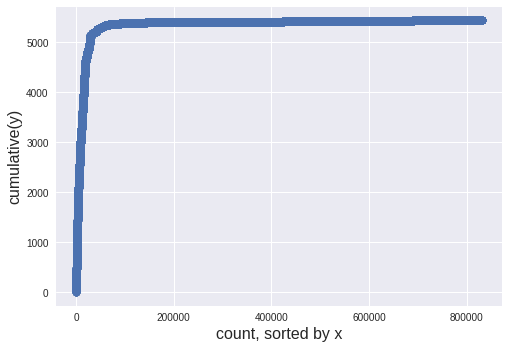

In [61]:
cumulative_sort_plot(asizes, ask_goes_next_tick)

Similarly, almost all "bid/ask gone" events happen after a tick in which the size on the bid/ask is at most a few dozen.

Mean and std dev of x: 158.31742875120156, 112.37505767993788
Percentile x-values:
10%: 29
20%: 57
30%: 87
40%: 120
50%: 147
60%: 171
70%: 199
80%: 236
90%: 296


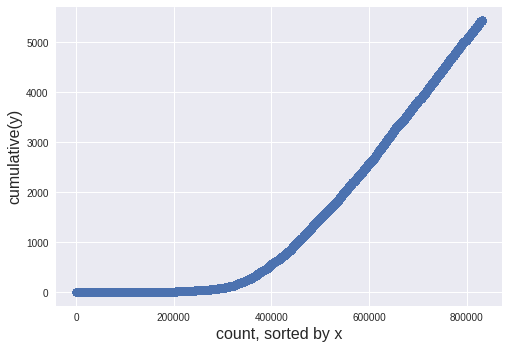

In [62]:
cumulative_sort_plot(asizes, bid_goes_next_tick)

Mean and std dev of x: 155.38878041209952, 108.74031660200203
Percentile x-values:
10%: 30
20%: 60
30%: 93
40%: 124
50%: 149
60%: 171
70%: 196
80%: 227
90%: 274


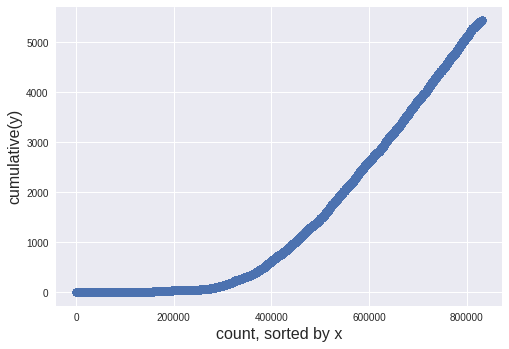

In [64]:
cumulative_sort_plot(bsizes, ask_goes_next_tick)

The bid/ask almost never "goes" if the size on the other side of the order book is small.

# Prepare features

Change the "empty behind" feature from a set to binary list.

In [65]:
empty_behind_bid = [i in empty_behind_bid for i in range(N)]
empty_behind_ask = [i in empty_behind_ask for i in range(N)]

In order to make the coefficients we get out of logistic regression somewhat interpretable, we want to transform the non-binary features to be approximately unit normal distributions. While log_sz_ratio is already symmetric, the top-of-book sizes have some skew. We take the square root to make them approximately symmetric.

The trade_cnts features are already close to binary (mostly zero, some values of order unity).

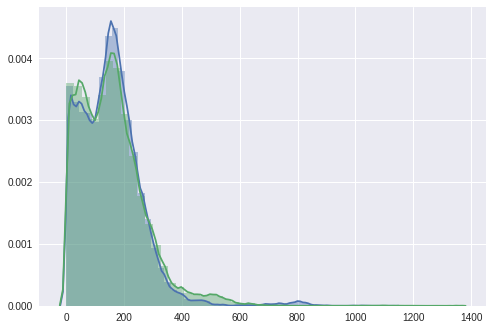

In [69]:
sns.distplot(bsizes), sns.distplot(asizes);

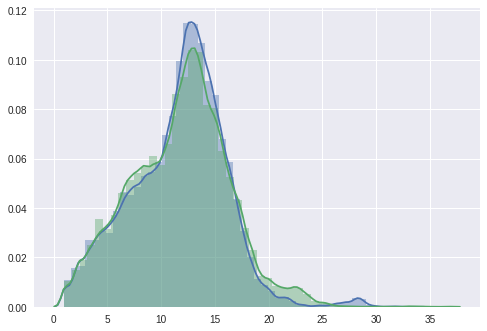

In [70]:
sns.distplot(np.sqrt(bsizes)), sns.distplot(np.sqrt(asizes));

In [72]:
features = pd.DataFrame({'sqrt_bsize': np.sqrt(bsizes),
                         'sqrt_asize': np.sqrt(asizes),
                         'log_sz_ratio': log_sz_ratios,
                         'trade_cnts_bid': trade_cnts_bid,
                         'trade_cnts_ask': trade_cnts_ask,
                         'empty_behind_bid': empty_behind_bid,
                         'empty_behind_ask': empty_behind_ask,
                        })

In [73]:
features['bsize_norm'] = (features['sqrt_bsize'] - features['sqrt_bsize'].mean()) / features['sqrt_bsize'].std()
features['asize_norm'] = (features['sqrt_asize'] - features['sqrt_asize'].mean()) / features['sqrt_asize'].std()
features['sz_ratio_norm'] = (features['log_sz_ratio'] - features['log_sz_ratio'].mean()) / features['log_sz_ratio'].std()

In [74]:
features = features.drop(columns=['sqrt_bsize', 'sqrt_asize', 'log_sz_ratio'])

In [76]:
np.save('bid_goes_next_tick.npy', bid_goes_next_tick)
np.save('ask_goes_next_tick.npy', ask_goes_next_tick)
features.to_pickle('features.pkl')

In [77]:
bid_goes_next_tick = np.load('bid_goes_next_tick.npy')
ask_goes_next_tick = np.load('ask_goes_next_tick.npy')
features = pd.read_pickle('features.pkl')

In [78]:
features.describe(include='all')

,trade_cnts_bid,trade_cnts_ask,empty_behind_bid,empty_behind_ask,bsize_norm,asize_norm,sz_ratio_norm
count,8.312070e+05,8.312070e+05,831207,831207,8.312070e+05,8.312070e+05,8.312070e+05
unique,NaN,NaN,2,2,NaN,NaN,NaN
top,NaN,NaN,False,False,NaN,NaN,NaN
freq,NaN,NaN,831159,831164,NaN,NaN,NaN
mean,1.109714e+00,1.209677e+00,NaN,NaN,1.356324e-12,6.741037e-13,8.108571e-16
std,4.920409e+00,5.121831e+00,NaN,NaN,1.000000e+00,1.000000e+00,1.000000e+00
min,0.000000e+00,0.000000e+00,NaN,NaN,-2.419799e+00,-2.336215e+00,-3.888714e+00
25%,0.000000e+00,0.000000e+00,NaN,NaN,-6.680344e-01,-7.172988e-01,-6.195179e-01
50%,0.000000e+00,0.000000e+00,NaN,NaN,1.238341e-01,8.891808e-02,9.406565e-03
75%,2.784920e-28,4.383006e-22,NaN,NaN,6.424365e-01,6.571547e-01,6.197166e-01


In [79]:
X = features.values
y = np.transpose(np.stack((bid_goes_next_tick, ask_goes_next_tick)))

In [80]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [81]:
y_train_bid, y_train_ask = np.transpose(y_train)
y_test_bid, y_test_ask = np.transpose(y_test)

# Baseline

The function deviance_loss is as defined in the GradientBoostingClassifier class, which we use below. The function is equal to twice the binary cross-entropy loss. It doesn't seem to be accessible outside of the GradientBoostingClassifier class. We verify below that our implementation matches sklearn's.

In [265]:
def deviance_loss(y_correct, y_log_odds):
    return -2.0 * np.mean((y_correct * y_log_odds) - np.logaddexp(0.0, y_log_odds))

As a most trivial baseline, we calculate the losses of always predicting that the probability of "bid/ask gone" is the frequency of these events in the trainig set. Note that among all constant predictions, predicting the correct frequency is the one which minimizes the deviance.

In [266]:
p_bid_gone = np.average(y_train_bid)
p_ask_gone = np.average(y_train_ask)
p_bid_gone, p_ask_gone

(0.0065191401051183148, 0.0065071093967351669)

In [267]:
y_baseline_bid = np.full((y_test_bid.size,), np.log(p_bid_gone / (1-p_bid_gone)))
y_baseline_ask = np.full((y_test_ask.size,), np.log(p_ask_gone / (1-p_ask_gone)))

In [268]:
deviance_loss(y_test_bid, y_baseline_bid), deviance_loss(y_test_ask, y_baseline_ask)

(0.079902248537924464, 0.080447193186705443)

So the baseline that we seek to beat is a deviance of 8% on the test set.

# Logistic regression

Advantages:
* simplicity
* interpretability of coefficients (for uncorrelated features)

Disadvantages:
* can only incorporate linear interactions between features
* assumes that linear combinations of features are meaningful; scaling of features matters

LogisticRegressionCV automatically chooses regularization parameters through cross-validation, but doesn't help with finding a good solver and regularization method. To do this, we split up X_train into X\_train\_ and X_val, and likewise for the y's.

In [269]:
X_train_, X_val, y_train_, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)
y_train_bid_, y_train_ask_ = np.transpose(y_train_)
y_val_bid, y_val_ask = np.transpose(y_val)

In [278]:
def train_and_validate(X_train, y_train, X_val, y_val, solver, penalty):
    clf = LogisticRegressionCV(cv=5, random_state=42, penalty=penalty, solver=solver)
    clf.fit(X_train, y_train)
    log_probs = clf.predict_log_proba(X_val)
    log_odds = log_probs[:,1] - log_probs[:,0]
    loss = deviance_loss(y_val, log_odds)    
    print(f'deviance loss out of sample: {loss:.4f}')
    return clf

We can't use the L-BFGS solver with L1-regularization.

In [329]:
train_and_validate(X_train_, y_train_bid_, X_val, y_val_bid, 'lbfgs', 'l2')
train_and_validate(X_train_, y_train_ask_, X_val, y_val_ask, 'lbfgs', 'l2')
train_and_validate(X_train_, y_train_bid_, X_val, y_val_bid, 'liblinear', 'l2')
train_and_validate(X_train_, y_train_ask_, X_val, y_val_ask, 'liblinear', 'l2')
train_and_validate(X_train_, y_train_bid_, X_val, y_val_bid, 'liblinear', 'l1')
train_and_validate(X_train_, y_train_ask_, X_val, y_val_ask, 'liblinear', 'l1')

deviance loss out of sample: 0.0340
deviance loss out of sample: 0.0337
deviance loss out of sample: 0.0348
deviance loss out of sample: 0.0345
deviance loss out of sample: 0.0352
deviance loss out of sample: 0.0348


LogisticRegressionCV(Cs=10, class_weight=None, cv=5, dual=False,
           fit_intercept=True, intercept_scaling=1.0, max_iter=100,
           multi_class='ovr', n_jobs=1, penalty='l1', random_state=42,
           refit=True, scoring=None, solver='liblinear', tol=0.0001,
           verbose=0)

L-BFGS with L2-regulariztion works best on the validation set. Now train a classifier with this setting on the full training set and test on the test set.

In [279]:
logreg_clf_bid = train_and_validate(X_train, y_train_bid, X_test, y_test_bid, 'lbfgs', 'l2')
logreg_clf_ask = train_and_validate(X_train, y_train_ask, X_test, y_test_ask, 'lbfgs', 'l2')

deviance loss out of sample: 0.0346
deviance loss out of sample: 0.0350


Logistic regression clearly outperforms the baseline on the test set.

In [280]:
features.columns

Index(['trade_cnts_bid', 'trade_cnts_ask', 'empty_behind_bid',
       'empty_behind_ask', 'bsize_norm', 'asize_norm', 'sz_ratio_norm'],
      dtype='object')

In [282]:
logreg_clf_bid.coef_, logreg_clf_ask.coef_

(array([[  4.87010488e-02,  -5.64345990e-02,   1.26329800e-01,
          -2.92707078e-06,  -2.97015630e+00,  -3.32129779e-01,
          -1.37157265e+00]]),
 array([[ -3.41108837e-02,   5.05781496e-02,  -2.13147714e-06,
           4.11460342e-01,  -3.70531387e-01,  -2.78253345e+00,
           1.50795425e+00]]))

Based on the regression coefficients, the size-based features seem most useful (note that all features have a scale of unity). Note that while bsize_norm and asize_norm have opposite-sign correlations with "bid/ask gone", the coefficients on both of these are negative in both classifiers. This is not so surprising because these are correlated with the sz_ratio_norm feature, whose coefficients have the expected sign.

Following are the regularization coefficients in the L2 regularization. The minimal and maximal regularization coefficients that LogisticRegressionCV tries by default are 1e-4 and 1e+4, respectively. N.B. that a smaller coefficient means more regularization. We note that sz_ratio_norm is minimally regularized (1e+4), while the trade_cnt features are (close to) maximally regularized (1e-4).

In [284]:
logreg_clf_bid.Cs_, logreg_clf_ask.Cs_

(array([  1.00000000e-04,   7.74263683e-04,   5.99484250e-03,
          4.64158883e-02,   3.59381366e-01,   2.78255940e+00,
          2.15443469e+01,   1.66810054e+02,   1.29154967e+03,
          1.00000000e+04]),
 array([  1.00000000e-04,   7.74263683e-04,   5.99484250e-03,
          4.64158883e-02,   3.59381366e-01,   2.78255940e+00,
          2.15443469e+01,   1.66810054e+02,   1.29154967e+03,
          1.00000000e+04]))

Finally, we check that both the size-based features on their own and all non-size-based features together produce notably worse models than the full set of features.

In [328]:
train_and_validate(X_train[:,:4], y_train_bid, X_test[:,:4], y_test_bid, 'lbfgs', 'l2')
train_and_validate(X_train[:,:4], y_train_ask, X_test[:,:4], y_test_ask, 'lbfgs', 'l2')
train_and_validate(X_train[:,4:], y_train_bid, X_test[:,4:], y_test_bid, 'lbfgs', 'l2')
train_and_validate(X_train[:,4:], y_train_ask, X_test[:,4:], y_test_ask, 'lbfgs', 'l2')

deviance loss out of sample: 0.0740
deviance loss out of sample: 0.0745
deviance loss out of sample: 0.0525
deviance loss out of sample: 0.0535


LogisticRegressionCV(Cs=10, class_weight=None, cv=5, dual=False,
           fit_intercept=True, intercept_scaling=1.0, max_iter=100,
           multi_class='ovr', n_jobs=1, penalty='l2', random_state=42,
           refit=True, scoring=None, solver='lbfgs', tol=0.0001, verbose=0)

# Gradient boosting model

Advantages:
* can represent complex interactions between features
* scaling of features doesn't matter
* insensitive to useless features
* hard to overfit
* has explicit "feature importances"

Disadvantages:
* hard to tune well
* lack of interpretability

One crucial hyperparameter in boosted decision trees is the max_depth of each tree. To choose between the values 2, 3, and 4 we perform 5-fold cross-validation using up to 400 trees. Once we have determined a good value for max_depth, we will train for longer (more than 400 trees).

Because our training set is quite large, we subsample 10% of our training set for each individual tree ("stochastic gradient boosting"). This both helps with regularization and speeds up training.

In [285]:
n_estimators = 400 

In [286]:
params = {'loss': 'deviance', 
          'n_estimators': n_estimators,
          'max_depth': -1, # try different values below 
          'subsample': 0.1, 
          'learning_rate': 0.01, 
          'min_samples_leaf': 10,
          'random_state': 42,
         }

In [311]:
def holdout_losses(clf, X_holdout, y_holdout):
    n_estimators = clf.n_estimators
    losses = np.zeros((n_estimators,), dtype=np.float64)
    for i, y_pred in enumerate(clf.staged_decision_function(X_holdout)):
        losses[i] = clf.loss_(y_holdout, y_pred) 
    return losses

In [312]:
def cv_estimate(X_train, y_train, params, n_splits):
    n_estimators = params['n_estimators']
    cv = KFold(n_splits=n_splits)
    cv_clf = ensemble.GradientBoostingClassifier(**params)
    val_losses = np.zeros((n_estimators,), dtype=np.float64)
    for train, test in cv.split(X_train, y_train):
        cv_clf.fit(X_train[train], y_train[train])
        val_losses += holdout_losses(cv_clf, X_train[test], y_train[test])
    return val_losses / n_splits

In [289]:
cross_val_losses = pd.DataFrame()

for max_depth in [2, 3, 4]:
    for side in ['bid', 'ask']:
        print(f'starting {side}, max_depth = {max_depth}')
        params['max_depth'] = max_depth
        y_train = y_train_bid if side == 'bid' else y_train_ask
        cross_val_losses[f'{side},{max_depth}'] = cv_estimate(X_train, y_train, params, n_splits=5) 

starting bid, max_depth = 2
starting ask, max_depth = 2
starting bid, max_depth = 3
starting ask, max_depth = 3
starting bid, max_depth = 4
starting ask, max_depth = 4


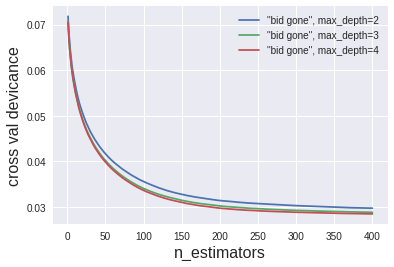

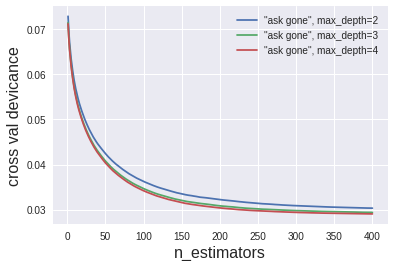

In [290]:
x = np.arange(n_estimators) + 1 
for side in ['bid', 'ask']:
    fig, ax = plt.subplots()
    for max_depth in [2, 3, 4]:
        ax.plot(x, cross_val_losses[f'{side},{max_depth}'], label=f'"{side} gone", max_depth={max_depth}')
    plt.xlabel('n_estimators', fontsize=16)
    plt.ylabel('cross val devicance', fontsize=16)
    ax.legend();

In [291]:
cross_val_losses.tail()

,"bid,2","ask,2","bid,3","ask,3","bid,4","ask,4"
395,0.029743,0.030346,0.028840,0.029394,0.028482,0.029059
396,0.029742,0.030341,0.028839,0.029390,0.028481,0.029057
397,0.029739,0.030338,0.028837,0.029387,0.028479,0.029056
398,0.029739,0.030333,0.028836,0.029384,0.028478,0.029052
399,0.029730,0.030332,0.028829,0.029384,0.028472,0.029051


Now train classifiers with max_depth = 4 for longer and on the whole training set.

In [318]:
params['max_depth'] = 4
params['n_estimators'] = 2000
params['verbose'] = 1

In [326]:
gbm_clf_bid = ensemble.GradientBoostingClassifier(**params)
gbm_clf_bid.fit(X_train, y_train_bid)

      Iter       Train Loss      OOB Improve   Remaining Time 
         1           0.0735           0.0082           13.65m
         2           0.0698           0.0032           12.40m
         3           0.0678           0.0023           12.97m
         4           0.0633           0.0019           13.30m
         5           0.0635           0.0016           13.41m
         6           0.0609           0.0014           13.46m
         7           0.0565           0.0012           13.54m
         8           0.0595           0.0011           13.48m
         9           0.0558           0.0010           13.44m
        10           0.0541           0.0010           13.27m
        20           0.0485           0.0005           11.94m
        30           0.0438           0.0003           11.47m
        40           0.0438           0.0003           11.23m
        50           0.0397           0.0002           11.33m
        60           0.0376           0.0002           11.28m
       

GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.01, loss='deviance', max_depth=4,
              max_features=None, max_leaf_nodes=None,
              min_impurity_split=1e-07, min_samples_leaf=10,
              min_samples_split=2, min_weight_fraction_leaf=0.0,
              n_estimators=2000, presort='auto', random_state=42,
              subsample=0.1, verbose=1, warm_start=False)

In [327]:
gbm_clf_ask = ensemble.GradientBoostingClassifier(**params)
gbm_clf_ask.fit(X_train, y_train_ask)

      Iter       Train Loss      OOB Improve   Remaining Time 
         1           0.0732           0.0077           10.71m
         2           0.0671           0.0032           10.90m
         3           0.0609           0.0023           11.32m
         4           0.0595           0.0019           11.57m
         5           0.0586           0.0017           11.69m
         6           0.0617           0.0014           11.79m
         7           0.0587           0.0012           11.85m
         8           0.0546           0.0011           11.89m
         9           0.0574           0.0011           11.76m
        10           0.0539           0.0009           11.68m
        20           0.0510           0.0005           11.94m
        30           0.0466           0.0003           11.74m
        40           0.0449           0.0003           11.49m
        50           0.0384           0.0002           11.46m
        60           0.0386           0.0002           11.17m
       

GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.01, loss='deviance', max_depth=4,
              max_features=None, max_leaf_nodes=None,
              min_impurity_split=1e-07, min_samples_leaf=10,
              min_samples_split=2, min_weight_fraction_leaf=0.0,
              n_estimators=2000, presort='auto', random_state=42,
              subsample=0.1, verbose=1, warm_start=False)

In [334]:
bid_test_losses = holdout_losses(gbm_clf_bid, X_test, y_test_bid)
ask_test_losses = holdout_losses(gbm_clf_ask, X_test, y_test_ask)

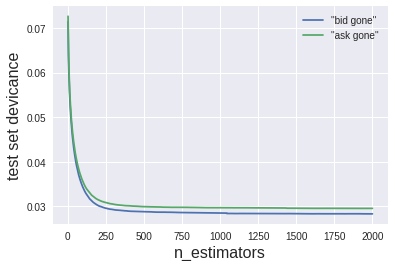

In [336]:
x = np.arange(2000) + 1 
fig, ax = plt.subplots()
ax.plot(x, bid_test_losses, label=f'"bid gone"')
ax.plot(x, ask_test_losses, label=f'"ask gone"')
plt.xlabel('n_estimators', fontsize=16)
plt.ylabel('test set devicance', fontsize=16)
ax.legend();

In [337]:
bid_test_losses[-1], ask_test_losses[-1]

(0.028298001336269911, 0.029528630582238837)

The gradient boosted trees do notably better than logistic regression, at the cost of being harder to tune and taking longer to train. We also note that the final training losses of the boosted trees (0.026) are only a little smaller than the final test set losses (0.028, 0.030), showing that with 2000 trees we are not yet seriously overfitting our training set.

Let us verify that we get the same loss values with our implementation of the deviance function.

In [344]:
def test_loss(clf, y_test):
    log_probs = clf.predict_log_proba(X_test)
    log_odds = log_probs[:,1] - log_probs[:,0]
    return deviance_loss(y_test, log_odds)

In [345]:
test_loss(gbm_clf_bid, y_test_bid), test_loss(gbm_clf_ask, y_test_ask)

(0.028298001336269911, 0.029528630582238837)

In [347]:
features.columns

Index(['trade_cnts_bid', 'trade_cnts_ask', 'empty_behind_bid',
       'empty_behind_ask', 'bsize_norm', 'asize_norm', 'sz_ratio_norm'],
      dtype='object')

In [348]:
gbm_clf_bid.feature_importances_, gbm_clf_ask.feature_importances_

(array([  2.61691935e-01,   6.33927511e-02,   2.63009198e-05,
          0.00000000e+00,   1.16027910e-01,   1.40597639e-01,
          4.18263464e-01]),
 array([  5.88330179e-02,   2.68814706e-01,   0.00000000e+00,
          2.84031336e-04,   1.38708490e-01,   1.02486377e-01,
          4.30873377e-01]))

We see that the features related to top-of-book sizes are most important, followed by the count of recent trades that happened on the side we are interested in.

In [373]:
with open('gbm_clf_bid.pkl', 'wb') as p:
    pickle.dump(gbm_clf_bid, p)

with open('gbm_clf_ask.pkl', 'wb') as p:
    pickle.dump(gbm_clf_ask, p)

# Output data set

We output the full data set of all features, whether the bid/ask "goes" on the next tick, and the probability our model assigns to these events. We index the data by the time of the respective tick.

In [82]:
with open('gbm_clf_bid.pkl', 'rb') as p:
    gbm_clf_bid = pickle.load(p)
    
with open('gbm_clf_ask.pkl', 'rb') as p:
    gbm_clf_ask = pickle.load(p)

In [83]:
full_data = features.copy()

In [84]:
full_data['bid_goes_next_tick'] = bid_goes_next_tick
full_data['ask_goes_next_tick'] = ask_goes_next_tick

In [85]:
prob_bid_goes_next_tick = gbm_clf_bid.predict_proba(features.values)
prob_ask_goes_next_tick = gbm_clf_ask.predict_proba(features.values)

In [90]:
full_data['prob_bid_goes_next_tick'] = prob_bid_goes_next_tick[:,1]
full_data['prob_ask_goes_next_tick'] = prob_ask_goes_next_tick[:,1]

In [92]:
full_data['time'] = [tick['time'] for tick in data]

In [94]:
full_data = full_data.set_index('time')

In [134]:
full_data.to_csv('full_data.csv')

# Visualizing model predictions

Let us see how the average probabilities prob\_{bid,ask}\_goes_next_tick change in the ticks around when these events actually happen.

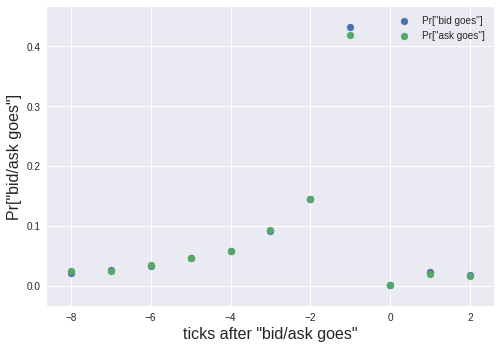

In [142]:
offsets = np.arange(-7, 4)
prob_bid_goes = [full_data[full_data['bid_goes_next_tick'].shift(o).fillna(False)]['prob_bid_goes_next_tick'].mean()
                for o in offsets]
prob_ask_goes = [full_data[full_data['ask_goes_next_tick'].shift(o).fillna(False)]['prob_ask_goes_next_tick'].mean()
                for o in offsets]
fig, ax = plt.subplots()
plt.scatter(offsets - 1, prob_bid_goes, label='Pr["bid goes"]')
plt.scatter(offsets - 1, prob_ask_goes, label='Pr["ask goes"]')
plt.xlabel('ticks after "bid/ask goes"', fontsize=16)
plt.ylabel('Pr["bid/ask goes"]', fontsize=16)
ax.legend();

We see that the model's predicted probability that the bid/ask "goes" on the next tick spikes right before it happens and then sharply drops on the tick on which the level "goes."

This can also be seen by looking at a few seconds of tick data.

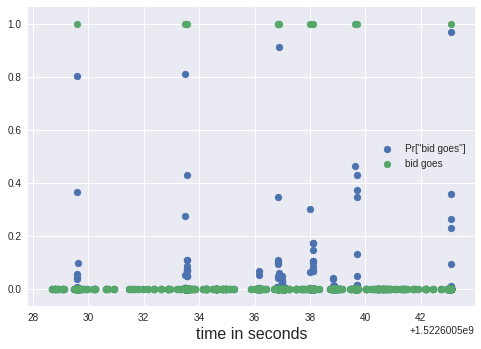

In [144]:
from_ = 10**5
to = from_+10**3
x = full_data.index[from_:to] / 10**9
fig, ax = plt.subplots()
plt.scatter(x, full_data['prob_bid_goes_next_tick'][from_:to], label='Pr["bid goes"]')
plt.scatter(x, full_data['bid_goes_next_tick'].shift(1).fillna(False)[from_:to], label="bid goes")
plt.xlabel('time in seconds', fontsize=16)
ax.legend();

# Discussion

Based on one day's worth of tick-level data, we tried to predict events in which a top-of-book price level (bid or ask) "goes." We saw that a number of features indeed have some predictive value: top-of-book size on the same and opposite side; recent trade count; the price level behind top-of-book being empty (this feature turned out to be not very useful, since it is rarely the case).

A logistic regression and gradient boosted decision trees both clearly outperformed a trivial baseline. Gradient boosting takes longer to train and has more hyperparameters to tune, but eventually led to better results. We saw that our model's predicted probability for a level "going" starts to increase several ticks before this actually happens, and reaches a sharp maximum on the tick right before it happens.

Our work could be extended both on the feature extraction and on the modelling side. On the feature side, we could include variations and extensions of the current features, such as trade counts with different half-lives or recent changes of the top-of-book sizes. (Intuition: if recently size has been added to the bid, then the bid is less likely to "go.") It also seems likely that top-of-book levels are less likely to "go" when the spread is larger than its minimal value of 5 (which is rarely the case). Other promising features are recent price moves, including price moves in other instruments which are correlated with the one we are studying but more liquid.

On the modelling side, our results could likely be improved by giving the numerous hyperparameters of the gradient boosted trees some more thought. Finally, it seems promising to try models that are inherently well-suited for time-series data, such as LSTM.